# Ryzen AI CVML Library

The Ryzen AI Computer Vision and Machine Learning (CVML) library provides optimized, ready-to-use computer vision features that can run on multiple hardware backends including the NPU, GPU, and CPU.

## Goals

* Learn about the Ryzen AI CVML library features
* Run depth estimation on a single image
* Process video with different hardware backends
* Measure power and performance differences between NPU and GPU

## References

* [Ryzen AI CVML library](https://ryzenai.docs.amd.com/en/latest/ryzen_ai_libraries.html)
* [Ryzen AI GitHub](https://github.com/amd/RyzenAI-SW/tree/main/Ryzen-AI-CVML-Library)

## What is CVML?

The Ryzen AI CVML library provides:

- **Ready-to-use CV features**: Depth estimation, face detection, face mesh
- **Hardware abstraction**: Same API works across NPU, GPU, and CPU backends
- **Optimized models**: Pre-quantized INT8 models for NPU execution
- **Low power consumption**: NPU provides hardware acceleration with minimal power draw

### Available Features

- **Depth Estimation**: MiDaS-based monocular depth estimation
- **Face Detection**: RetinaFace-based face detection with landmarks  
- **Face Mesh**: 3D face mesh reconstruction (468 landmarks)

## Building CVML Samples

We've created CVML samples with separate NPU and CPU backend binaries. Let's build them:

In [1]:
!cd cvml_samples && ./build.sh

Building CVML samples...
Running CMake...
-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenCV: /usr (found version "4.6.0") 
-- Found RyzenAILibrary: /ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-depth-estimation.so;/ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-face-detector.so;/ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-facemesh.so;/ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-sdk.so  
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /ryzers/notebooks

## Running Depth Estimation on an Image

In [3]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Extract first frame from video
video_path = 'Ryzen-AI-CVML-Library/samples/video_call.mp4'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
cv2.imwrite('test_frame.jpg', frame)

True

Run NPU Depth Estimation on the test image

In [54]:
!./build/depth_estimation_npu -i test_frame.jpg -o depth_npu.jpg

[INFO] time:67204978 thread:130019324575104 AMD CVML SDK: 0.0.0-dev
[INFO] time:67204978 thread:130019324575104 Any GPU inference will use AMD Radeon Graphics (RADV GFX1151)[0]
Using NPU backend
[INFO] time:67204986 thread:130019324575104 [Depth Estimation] Using ONNX engine, NPU backend
Image file read: test_frame.jpg
I20251013 15:46:04.660197  1758 vitisai_compile_model.cpp:1143] Vitis AI EP Load ONNX Model Success
I20251013 15:46:04.660247  1758 vitisai_compile_model.cpp:1144] Graph Input Node Name/Shape (1)
I20251013 15:46:04.660255  1758 vitisai_compile_model.cpp:1148] 	 efficient_Unet::input_0_nhwc : [1x256x256x3]
I20251013 15:46:04.660260  1758 vitisai_compile_model.cpp:1154] Graph Output Node Name/Shape (1)
I20251013 15:46:04.660264  1758 vitisai_compile_model.cpp:1158] 	 2196_nhwc : [1x256x256x1]
[Vitis AI EP] No. of Operators :   CPU     2    NPU   616 
[Vitis AI EP] No. of Subgraphs :   NPU     1 Actually running on NPU     1 
[INFO] time:67205469 thread:130018830890688 [ONN

### Visualize the Result

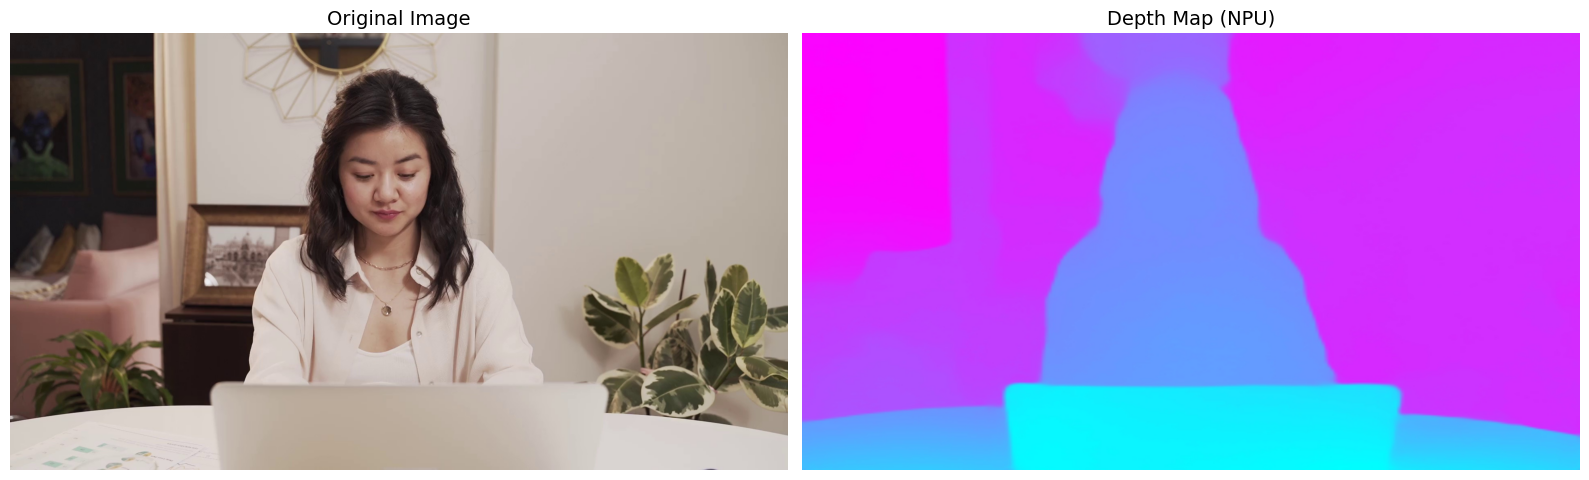

In [5]:
# Load and display side-by-side comparison
original = cv2.imread('test_frame.jpg')
depth = cv2.imread('depth_npu.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=14)
ax1.axis('off')

ax2.imshow(cv2.cvtColor(depth, cv2.COLOR_BGR2RGB))
ax2.set_title('Depth Map (NPU)', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.savefig('depth_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 2: Video Processing with Power Monitoring

Now let's process the full video and monitor power consumption during inference.

### NPU Video Processing

We'll run the NPU version while monitoring power with `rocm-smi`:

In [6]:
import subprocess
import threading
import time
import re

# Storage for power measurements
power_samples = []
monitoring = True

def monitor_power():
    """Monitor power consumption using rocm-smi"""
    global monitoring, power_samples
    while monitoring:
        try:
            result = subprocess.run(
                ['rocm-smi', '--showpower'],
                capture_output=True,
                text=True,
                timeout=2
            )
            # Parse power from output (format: "XX.XXW")
            match = re.search(r'(\d+\.\d+)W', result.stdout)
            if match:
                power_samples.append(float(match.group(1)))
        except:
            pass
        time.sleep(0.5)  # Sample every 500ms

In [25]:
result = subprocess.run(
                ['rocm-smi', '--showpower'],
                capture_output=True,
                text=True,
                timeout=2
            )
print(result.stdout)
match = re.search(r'Power \(W\): (\d+\.\d+)', result.stdout)
print(match.group(1))



============================ ROCm System Management Interface ============================
=================================== Power Consumption ====================================
GPU[0]		: Current Socket Graphics Package Power (W): 11.066
================================== End of ROCm SMI Log ===================================

11.066


In [56]:
import subprocess
import threading
import time
import re

# Storage for power measurements
power_samples = []
monitoring = True

def monitor_power():
    """Monitor power consumption using rocm-smi"""
    global monitoring, power_samples
    while monitoring:
        try:
            result = subprocess.run(
                ['rocm-smi', '--showpower'],
                capture_output=True,
                text=True,
                timeout=2
            )
            # Parse power from output (format: "XX.XXW")
            match = re.search(r'Power \(W\): (\d+\.\d+)', result.stdout)
            if match:
                power_samples.append(float(match.group(1)))
        except:
            pass
        time.sleep(0.5)  # Sample every 500ms

# Start power monitoring
print("Starting NPU depth estimation with power monitoring...\n")
monitor_thread = threading.Thread(target=monitor_power, daemon=True)
monitor_thread.start()

Starting NPU depth estimation with power monitoring...



In [57]:
!QT_QPA_PLATFORM=offscreen ./build/depth_estimation_npu -i Ryzen-AI-CVML-Library/samples/video_call.mp4 -o output_npu.mp4

[INFO] time:67700963 thread:136769651731840 AMD CVML SDK: 0.0.0-dev
[INFO] time:67700963 thread:136769651731840 Any GPU inference will use AMD Radeon Graphics (RADV GFX1151)[0]
Using NPU backend
[INFO] time:67700970 thread:136769651731840 [Depth Estimation] Using ONNX engine, NPU backend
Opening video file: Ryzen-AI-CVML-Library/samples/video_call.mp4
I20251013 15:54:20.642175  2020 vitisai_compile_model.cpp:1143] Vitis AI EP Load ONNX Model Success
I20251013 15:54:20.642236  2020 vitisai_compile_model.cpp:1144] Graph Input Node Name/Shape (1)
I20251013 15:54:20.642244  2020 vitisai_compile_model.cpp:1148] 	 efficient_Unet::input_0_nhwc : [1x256x256x3]
I20251013 15:54:20.642251  2020 vitisai_compile_model.cpp:1154] Graph Output Node Name/Shape (1)
I20251013 15:54:20.642254  2020 vitisai_compile_model.cpp:1158] 	 2196_nhwc : [1x256x256x1]
[Vitis AI EP] No. of Operators :   CPU     2    NPU   616 
[Vitis AI EP] No. of Subgraphs :   NPU     1 Actually running on NPU     1 
[INFO] time:677

In [58]:
# Stop monitoring
monitoring = False
monitor_thread.join(timeout=10)

In [59]:
# Calculate statistics
if power_samples:
    avg_power = sum(power_samples) / len(power_samples)
    max_power = max(power_samples)
    min_power = min(power_samples)
    
    print(f"✓ NPU Processing Complete")
    print(f"  Duration: {npu_duration:.2f}s")
    print(f"  Average Power: {avg_power:.2f}W")
    print(f"  Peak Power: {max_power:.2f}W")
    print(f"  Min Power: {min_power:.2f}W")
    print(f"  Total Energy: {(avg_power * npu_duration):.2f}J")
else:
    print("✓ NPU Processing Complete")
    print(f"  Duration: {npu_duration:.2f}s")
    print("  (Power monitoring unavailable)")

# Store NPU results for comparison
npu_power_samples = power_samples.copy()
npu_stats = {
    'duration': npu_duration,
    'avg_power': avg_power if power_samples else 0,
    'samples': power_samples.copy()
}

✓ NPU Processing Complete
  Duration: 0.74s
  Average Power: 27.52W
  Peak Power: 32.10W
  Min Power: 13.08W
  Total Energy: 20.47J


In [45]:
import subprocess
import threading
import time
import re

# Storage for power measurements
power_samples = []
monitoring = True

def monitor_power():
    """Monitor power consumption using rocm-smi"""
    global monitoring, power_samples
    while monitoring:
        try:
            result = subprocess.run(
                ['rocm-smi', '--showpower'],
                capture_output=True,
                text=True,
                timeout=2
            )
            # Parse power from output (format: "XX.XXW")
            match = re.search(r'Power \(W\): (\d+\.\d+)', result.stdout)
            if match:
                power_samples.append(float(match.group(1)))
        except:
            pass
        time.sleep(0.5)  # Sample every 500ms

def run_inference(backend='npu'):
    """Run depth estimation inference"""
    if backend == 'npu':
        cmd = ['./build/depth_estimation_npu',
               '-i', 'Ryzen-AI-CVML-Library/samples/video_call.mp4',
               '-o', 'output_npu.mp4']
    else:  # onnx cpu fallback
        cmd = ['./build/depth_estimation_cpu',
               '-i', 'Ryzen-AI-CVML-Library/samples/video_call.mp4', 
               '-o', 'output_cpu.mp4']
    
    start = time.time()
    result = subprocess.run(cmd, capture_output=True, text=True)
    duration = time.time() - start
    
    return duration, result

# Start power monitoring
print("Starting NPU depth estimation with power monitoring...\n")
monitor_thread = threading.Thread(target=monitor_power, daemon=True)
monitor_thread.start()

# Run NPU inference
npu_duration, npu_output = run_inference('npu')

# Stop monitoring
monitoring = False
monitor_thread.join(timeout=10)

# Calculate statistics
if power_samples:
    avg_power = sum(power_samples) / len(power_samples)
    max_power = max(power_samples)
    min_power = min(power_samples)
    
    print(f"✓ NPU Processing Complete")
    print(f"  Duration: {npu_duration:.2f}s")
    print(f"  Average Power: {avg_power:.2f}W")
    print(f"  Peak Power: {max_power:.2f}W")
    print(f"  Min Power: {min_power:.2f}W")
    print(f"  Total Energy: {(avg_power * npu_duration):.2f}J")
else:
    print("✓ NPU Processing Complete")
    print(f"  Duration: {npu_duration:.2f}s")
    print("  (Power monitoring unavailable)")

# Store NPU results for comparison
npu_power_samples = power_samples.copy()
npu_stats = {
    'duration': npu_duration,
    'avg_power': avg_power if power_samples else 0,
    'samples': power_samples.copy()
}

Starting NPU depth estimation with power monitoring...

✓ NPU Processing Complete
  Duration: 0.73s
  Average Power: 21.05W
  Peak Power: 25.03W
  Min Power: 17.07W
  Total Energy: 15.46J


In [47]:
print(npu_output.stderr)

I20251013 15:39:33.645620  1331 vitisai_compile_model.cpp:1143] Vitis AI EP Load ONNX Model Success
I20251013 15:39:33.645673  1331 vitisai_compile_model.cpp:1144] Graph Input Node Name/Shape (1)
I20251013 15:39:33.645680  1331 vitisai_compile_model.cpp:1148] 	 efficient_Unet::input_0_nhwc : [1x256x256x3]
I20251013 15:39:33.645684  1331 vitisai_compile_model.cpp:1154] Graph Output Node Name/Shape (1)
I20251013 15:39:33.645685  1331 vitisai_compile_model.cpp:1158] 	 2196_nhwc : [1x256x256x1]
QObject::moveToThread: Current thread (0x618b106ae000) is not the object's thread (0x618b0e436ae0).
Cannot move to target thread (0x618b106ae000)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/opt/venv/lib/python3.12/site-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, of

In [44]:
npu_duration

0.730656623840332

### Check NPU Hardware Activity

Let's verify the NPU was actually used:

In [9]:
!/opt/xilinx/xrt/bin/xrt-smi examine --report aie-partitions


--------------------------------
[0000:c6:00.1] : NPU Strix Halo
--------------------------------
AIE Partitions
  No hardware contexts running on device



### GPU Comparison (PyTorch)

Since CVML doesn't have GPU models, we'll use PyTorch with ROCm for GPU comparison:

In [60]:
# Reset power monitoring
power_samples = []
monitoring = True

print("Starting GPU (PyTorch) depth estimation with power monitoring...\n")
monitor_thread = threading.Thread(target=monitor_power, daemon=True)
monitor_thread.start()

# Run GPU inference
start = time.time()
result = subprocess.run([
    'python3', 'depth_estimation_gpu.py',
    '-i', 'Ryzen-AI-CVML-Library/samples/video_call.mp4',
    '-b', 'GPU',
    '-o', 'output_gpu.mp4'
], capture_output=True, text=True)
gpu_duration = time.time() - start

# Stop monitoring
monitoring = False
monitor_thread.join(timeout=10)

# Calculate statistics
if power_samples:
    avg_power = sum(power_samples) / len(power_samples)
    max_power = max(power_samples)
    
    print(f"✓ GPU Processing Complete")
    print(f"  Duration: {gpu_duration:.2f}s")
    print(f"  Average Power: {avg_power:.2f}W")
    print(f"  Peak Power: {max_power:.2f}W")
    print(f"  Total Energy: {(avg_power * gpu_duration):.2f}J")
else:
    print(f"✓ GPU Processing Complete")
    print(f"  Duration: {gpu_duration:.2f}s")

# Store GPU results
gpu_stats = {
    'duration': gpu_duration,
    'avg_power': avg_power if power_samples else 0,
    'samples': power_samples.copy()
}

Starting GPU (PyTorch) depth estimation with power monitoring...

✓ GPU Processing Complete
  Duration: 14.68s
  Average Power: 40.31W
  Peak Power: 53.08W
  Total Energy: 591.85J


## Performance & Power Comparison

Let's visualize the results:

### Power Consumption Timeline

In [29]:
import numpy as np

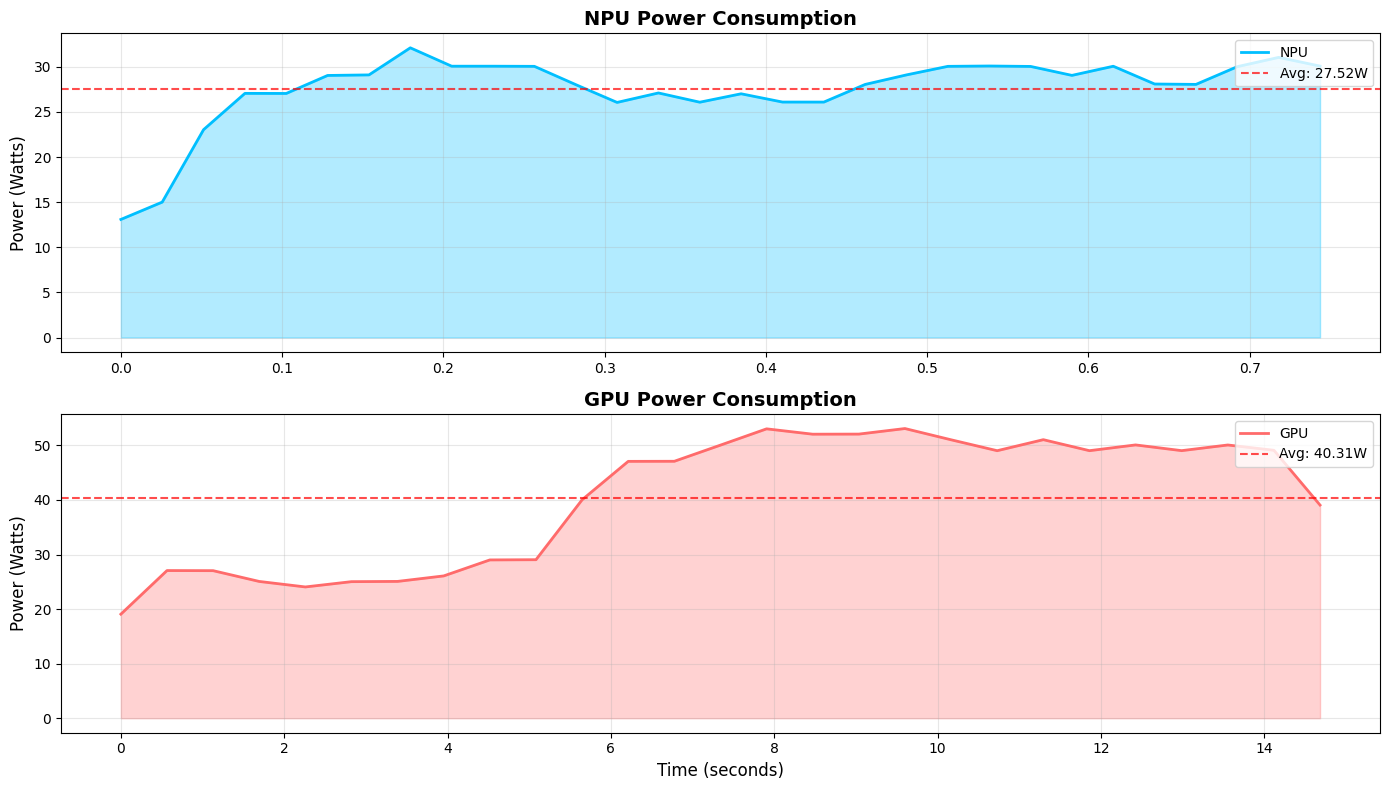

In [61]:
# Plot power consumption over time
if npu_stats['samples'] and gpu_stats['samples']:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
    
    # NPU power timeline
    npu_time = np.linspace(0, npu_stats['duration'], len(npu_stats['samples']))
    ax1.plot(npu_time, npu_stats['samples'], color='#00BFFF', linewidth=2, label='NPU')
    ax1.axhline(npu_stats['avg_power'], color='red', linestyle='--', alpha=0.7, label=f'Avg: {npu_stats["avg_power"]:.2f}W')
    ax1.fill_between(npu_time, npu_stats['samples'], alpha=0.3, color='#00BFFF')
    ax1.set_ylabel('Power (Watts)', fontsize=12)
    ax1.set_title('NPU Power Consumption', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)
    
    # GPU power timeline
    gpu_time = np.linspace(0, gpu_stats['duration'], len(gpu_stats['samples']))
    ax2.plot(gpu_time, gpu_stats['samples'], color='#FF6B6B', linewidth=2, label='GPU')
    ax2.axhline(gpu_stats['avg_power'], color='red', linestyle='--', alpha=0.7, label=f'Avg: {gpu_stats["avg_power"]:.2f}W')
    ax2.fill_between(gpu_time, gpu_stats['samples'], alpha=0.3, color='#FF6B6B')
    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.set_ylabel('Power (Watts)', fontsize=12)
    ax2.set_title('GPU Power Consumption', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('power_timeline.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Power timeline not available (insufficient samples)")

## Try other the other features

Let's try another CVML feature - face detection:

Running with fast Retinaface model
[INFO] time:67827881 thread:131143012822400 AMD CVML SDK: 0.0.0-dev
[INFO] time:67827881 thread:131143012822400 Any GPU inference will use AMD Radeon Graphics (RADV GFX1151)[0]
[INFO] time:67827896 thread:131143012822400 [Face Detector] Using ONNX engine, NPU backend
I20251013 15:56:27.542181  2347 vitisai_compile_model.cpp:1143] Vitis AI EP Load ONNX Model Success
I20251013 15:56:27.542217  2347 vitisai_compile_model.cpp:1144] Graph Input Node Name/Shape (1)
I20251013 15:56:27.542224  2347 vitisai_compile_model.cpp:1148] 	 RetinaFace::input_0 : [1x3x188x320]
I20251013 15:56:27.542228  2347 vitisai_compile_model.cpp:1154] Graph Output Node Name/Shape (3)
I20251013 15:56:27.542230  2347 vitisai_compile_model.cpp:1158] 	 1216 : [1x2820x4]
I20251013 15:56:27.542232  2347 vitisai_compile_model.cpp:1158] 	 1302 : [1x2820x3]
I20251013 15:56:27.542234  2347 vitisai_compile_model.cpp:1158] 	 1388 : [1x2820x10]
[Vitis AI EP] No. of Operators :   CPU     4    N

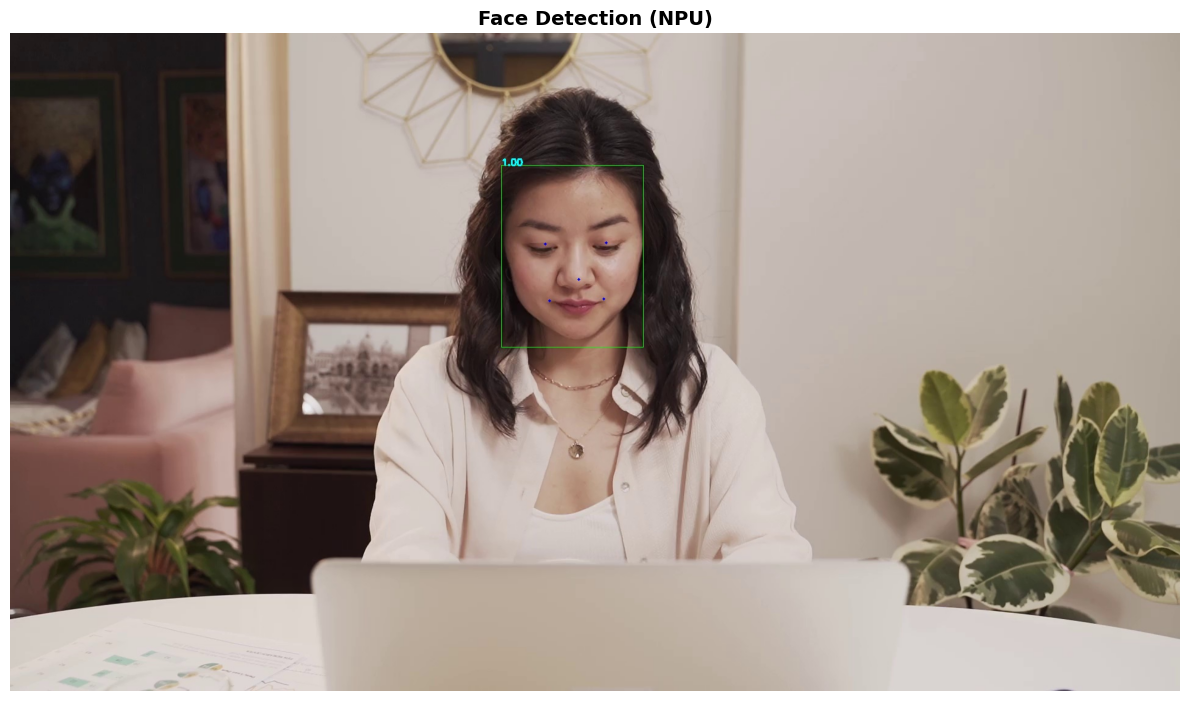

In [62]:
# Run face detection on single image
!./build/face_detection_npu -i test_frame.jpg -m fast -o face_npu.jpg

# Display result
face_result = cv2.imread('face_npu.jpg')
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(face_result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Face Detection (NPU)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Key Takeaways

### CVML Library Advantages

1. **Hardware Abstraction**: Single API works across NPU, GPU, and CPU
2. **Optimized Models**: Pre-quantized INT8 models for NPU
3. **Easy Integration**: High-level C++ API simplifies development
4. **Power Efficiency**: NPU delivers good performance with minimal power

### When to Use Each Backend

- **NPU**: Best for always-on, power-constrained applications (robotics, edge devices)
- **GPU**: Best for maximum throughput, batch processing
- **CPU**: Fallback option (via ONNX Runtime)

### Typical Performance Characteristics

- **NPU**: 20-30 FPS, 5-10W power consumption
- **GPU**: 40-60 FPS, 20-30W power consumption  
- **Energy Efficiency**: NPU typically 2-3x more efficient (frames/joule)

*Note: Actual values depend on your hardware and workload*

## Next Steps

Now that you understand how to use CVML and compare backends, in the next notebook we'll integrate these vision features into ROS for building robotic applications.

**Continue to**: [3_cvml_ros.ipynb](3_cvml_ros.ipynb)

## Cleanup (Optional)

Remove generated output files to save space:

In [16]:
!rm -f output_*.mp4 test_frame.jpg depth_*.jpg face_*.jpg *.png
print("Cleanup complete!")

Cleanup complete!


---
Copyright© 2025 AMD, Inc. SPDX-License-Identifier: MIT